# Assigment 11 | Applied Machine Learning | Paras Ahuja

### 1. In this assignment, we will use Apriori analysis to find noun phrases, or interesting patterns in a novel. Use nltk library corpus gutenberg API and load the novel 'carroll-alice.txt' which is the Alice in Wonderland by L. Carroll. There are 1703 sentences in the novel which can be represented as 1703 transactions. Use any means to parse/extract words and save in CSV format to be read by Weka framework similar to the Apriori Analysis module.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg, stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import os 
import struct
from itertools import combinations
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning
from sklearn.datasets import load_digits
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [2]:
stop_words = stopwords.words('english')
sentences = gutenberg.sents('carroll-alice.txt')
terms_sentences = []
for terms in sentences:    
    terms = [w for w in terms if w not in stop_words]    
    terms = [w for w in terms if re.search(r'^[a-zA-Z]{2}', w) is not None]
    if len(terms) > 0:
        terms = [w.lower() for w in terms]
        terms_sentences.append(terms)

Let's find out some of the most frequently used words.

In [3]:
raw = ""
for terms in terms_sentences:
    for term in terms:
        raw += term + " "

In [4]:
tokens = word_tokenize(raw)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)

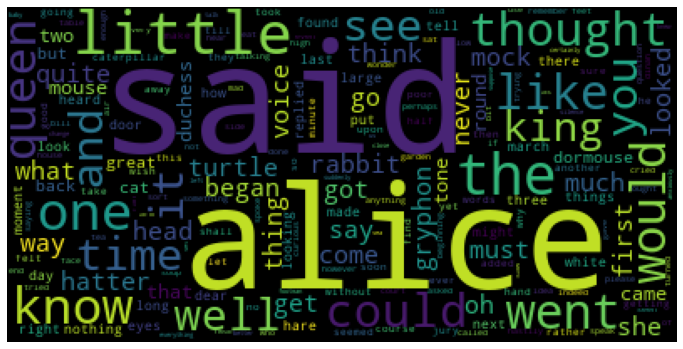

In [5]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequency_dist)
fig=plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Above we see word cloud based on frequency of the words used.

In [6]:
transactions_list = []  # a list of transactions
items_names = {}  # Lookup item ID to name
items_ids = {}  # Lookup item name to ID

# Process the data
item_id = 0
for terms in terms_sentences:
    transaction = []
    for term in terms:
        if term not in items_ids:
            items_ids[term] = item_id
            items_names[item_id] = term
            item_id += 1
            transaction += [items_ids[term]]
        transactions_list += [transaction]

m, n = len(items_ids), len(transactions_list)

items = np.arange(0,m)

# Information
print(f'M={m} items, N={n} transactions')

M=2512 items, N=13357 transactions


In [7]:
# Sanity check
print([items_names[_] for _ in items[0:7]])
print(transactions_list[:7])

['alice', 'adventures', 'wonderland', 'lewis', 'carroll', 'chapter', 'down']
[[0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [5], [6, 7, 8]]


In [8]:
# Convert to numpy arrays
transactions = np.full((n,m), False, dtype=np.bool)

for i, t in enumerate(transactions_list):
    for term in t:
        transactions[i][term] = True

print(f'{transactions[0:12].astype(int)}')

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [9]:
filename = 'a11_weka.csv'

with open(filename, 'w') as fout:
    writer = csv.writer(fout, delimiter=',', quoting=csv.QUOTE_ALL, quotechar="'", lineterminator='\n')
    writer.writerow([items_names[i] for i in range(m)])
    for i in range(n):
        writer.writerow(list(map(lambda x: '' if x == False else 'True',  transactions[i])))

In [10]:
df = pd.read_csv('a11_weka.csv')

### 2. The module class NeuralNetMLP is a single hidden layer neural network implementation. Make the necessary modifications to upgrade it to a 2 hidden layer network. Run it on the MNIST dataset and report its performance.

In [11]:
def load_mnist(path, kind="train"):
    labels_path = os.path.join(path, "%s-labels.idx1-ubyte" % kind)
    images_path = os.path.join(path, "%s-images.idx3-ubyte" % kind)
    with open(labels_path, "rb") as lbpath:
        magic, n = struct.unpack(">II", lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        with open(images_path, "rb") as imgpath:
            magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
            images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
            images = ((images/255.) - .5) * 2
    return images, labels

X_train, y_train = load_mnist('datasets/', kind="train")
X_test, y_test = load_mnist('datasets/', kind="t10k")
print(f'Rows={X_train.shape[0]}, Columns={X_train.shape[1]}')
print(f'Rows={X_test.shape[0]}, Columns={X_test.shape[1]}')

Rows=60000, Columns=784
Rows=10000, Columns=784


In [12]:
%%time

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    mlp = MLPClassifier(hidden_layer_sizes=(20,20), max_iter=300)
    mlp.fit(X_train, y_train)
    
y_pred = mlp.predict(X_test)
test_acc = ((sum(y_test == y_pred)).astype(np.float)/y_test.shape[0])
print(f'Test Accuracy = {test_acc * 100:.2f}%')

Test Accuracy = 94.99%
CPU times: user 36min 23s, sys: 6.42 s, total: 36min 29s
Wall time: 4min 34s


Another way of performing the task could be:

In [13]:
def kfold(clf, X, y, splits=10, shuffle=True, random_state=10):
    score_acc = []
    score_f1 = []
    kfold = StratifiedKFold(n_splits=splits, shuffle=shuffle, random_state=random_state)
    for train_index, test_index in kfold.split(X, y):
        clfr = clf.fit(X[train_index], y[train_index])
        y_pred = clfr.predict(X[test_index])
        score_f1 += [f1_score(y[test_index], y_pred, average='micro')]
        score_acc += [accuracy_score(y[test_index], y_pred)]
    return np.mean(np.array(score_f1)), np.mean(np.array(score_acc))

In [14]:
X = load_digits()["images"]
X = X.reshape((len(X), -1))
y = load_digits()["target"]

In [15]:
layers = (64, 64)
mlpc = MLPClassifier(layers)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    f1, accuracy = kfold(mlpc, X, y)
    
print(f'F1 Score = {f1 * 100:.2f}%')
print(f'Accuracy Score = {accuracy * 100:.2f}%')

F1 Score = 97.44%
Accuracy Score = 97.44%


We notice that with 10 fold cross validation our performance is 97.44%.